In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
box = 'Box_n50_0_1400'
param_names = ['d','e','f','g']
ndim = len(param_names)

In [3]:
from aemulusnu_massfunction.utils import *
from aemulusnu_massfunction.massfunction import *

import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import os
import emcee
import sys
import numpy as np
import pickle

In [5]:
cosmos_f = open('../data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

In [6]:
import pyccl as ccl

cosmo = cosmo_params[box]


h = cosmo['H0']/100
Ωb =  cosmo['ombh2'] / h**2
Ωc =  cosmo['omch2'] / h**2

ccl_cosmo = ccl.Cosmology(Omega_c=Ωc,
                      Omega_b=Ωb,
                      h=h,
                      A_s=cosmo['10^9 As']*10**(-9),
                      n_s=cosmo['ns'],
                      w0=cosmo['w0'],
                      m_nu=[cosmo['nu_mass_ev']/3, cosmo['nu_mass_ev']/3, cosmo['nu_mass_ev']/3])



In [7]:
h = cosmo['H0']/100

NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

In [8]:
a_fit = 1.0

In [9]:
N_data = {}
M_data = {}
aux_data = {}
from scipy.interpolate import interp1d, UnivariateSpline, InterpolatedUnivariateSpline


vol = -1 #Mpc^3/h^3
Mpart = -1

for a in tqdm([a_fit]):
    c_data = NvMs[a]
    
    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))
    

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = []
    M_data[a] = []
    aux_data[a] = []
    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data[a] += [N_curr]
        M_data[a] += [M_curr]
        aux_data[a] += [{'a':a, 'edge_pair':edge_pair}]


100%|██████████| 1/1 [00:00<00:00, 13189.64it/s]


In [10]:
a_list = list(NvMs.keys())

from scipy.stats import poisson


M_numerics = np.logspace(np.log10(100*Mpart), 16, 50)

jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()

In [11]:
jack_covs = {a:jackknife[a][1] for a in N_data}

weighted_cov = {a: jack_covs[a] for a in jack_covs}

# Inverse of the weighted covariance matrix
inv_weighted_cov = {a:np.linalg.inv(weighted_cov[a]) for a in weighted_cov}  
# inv_weighted_cov = {a:np.diag([1 for _ in range(len(weighted_cov[a]))]) for a in weighted_cov}  

scale_cov = {a:np.log(np.linalg.det(weighted_cov[a])) for a in weighted_cov}

In [12]:
def uniform_log_prior(param_values):
    #uniform prior
    for param in param_values:
        if(param < 0 or param > 10):
            return -np.inf
    return 0

In [13]:
print(len(jack_covs[1.0]))
print(len(N_data[1.0]))

25
25


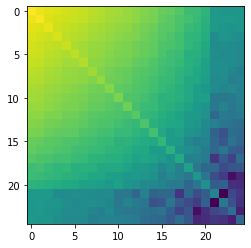

In [14]:
plt.imshow(np.log(np.abs(weighted_cov[a])))

In [15]:
mass_function = MassFuncAemulusNu_fitting()
mass_function.set_params([0.5, 1.12, 2.3, 1.3])
mass_function(ccl_cosmo, M_numerics/h, a_fit)*vol/(h**3 * M_numerics * np.log(10))
# tinker_eval = [mass_function(a, M_c, **params)*vol for M_c in M_numerics]


array([3.99063554e-07, 2.93725376e-07, 2.16038045e-07, 1.58768412e-07,
       1.16572570e-07, 8.55019042e-08, 6.26385897e-08, 4.58278604e-08,
       3.34787066e-08, 2.44161074e-08, 1.77730159e-08, 1.29099347e-08,
       9.35515113e-09, 6.76103768e-09, 4.87161903e-09, 3.49841982e-09,
       2.50282047e-09, 1.78298463e-09, 1.26415957e-09, 8.91539316e-10,
       6.25004606e-10, 4.35227537e-10, 3.00803907e-10, 2.06150655e-10,
       1.39949644e-10, 9.40022105e-11, 6.23897222e-11, 4.08558606e-11,
       2.63534489e-11, 1.67126366e-11, 1.03981530e-11, 6.33181512e-12,
       3.76339727e-12, 2.17657533e-12, 1.22065661e-12, 6.61182299e-13,
       3.44354889e-13, 1.71565976e-13, 8.12963407e-14, 3.63955704e-14,
       1.52785197e-14, 5.96240141e-15, 2.14181400e-15, 7.00250390e-16,
       2.05688948e-16, 5.34807460e-17, 1.21001730e-17, 2.33579869e-18,
       3.76056928e-19, 4.91848942e-20])

In [16]:
def log_prob(param_values):   
    """
    Calculates the probability of the given tinker parameters 
    
    Args:
        param_values (np.ndarray): Input array of shape (number of params).
        
    Returns:
        float: Resulting log probability
    """

    if(uniform_log_prior(param_values) == -np.inf):
        return -np.inf

    params = dict(zip(param_names, param_values))

    tinker_fs = {}
    
    
    mass_function.set_params(param_values)
    tinker_eval = mass_function(ccl_cosmo, M_numerics/h, a_fit)*vol/(h**3 * M_numerics * np.log(10))
    f_dNdM = interp1d(M_numerics, tinker_eval, kind='linear', bounds_error=False, fill_value=0.)
    tinker_fs[a_fit] = f_dNdM
        
    model_vals = {}
    model_vals[a_fit] = np.array([quad(tinker_fs[a], edge_pair[0], edge_pair[1], epsabs=0, epsrel=1e-5)[0]
        for edge_pair in NvMs[a_fit]['edge_pairs']
    ])

    
    residuals = {a: model_vals[a]-N_data[a] for a in model_vals}
    log_probs = [ -0.5 * (len(inv_weighted_cov)* np.log(2*np.pi) + 
                          np.dot(np.dot(residuals[a].T, inv_weighted_cov[a]), residuals[a]) + 
                          scale_cov[a]) 
                 for a in model_vals]
    if not np.isfinite(np.sum(log_probs)): 
        return -np.inf
    return np.sum(log_probs)


In [17]:
def log_likelihood(param_values):
    lp = uniform_log_prior(param_values)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_prob(param_values)

In [24]:
#from previous fit
guess_dict = {'d': 0.5288169627956, 'e': 1.12, 'f': 2.3235554777742466, 'g': 1.2847645464014752}
guess = list(guess_dict.values())


In [25]:
-log_likelihood(guess)

16847.959729968643

In [26]:
print('Starting ML Fit')
#Start by sampling with a maximum likelihood approach
from scipy import optimize as optimize
nll = lambda *args: -log_likelihood(*args)
bounds = [(0.48,.55), (1.1,1.4), (2.2,2.4), (1.2,1.3)]
result = optimize.minimize(nll, guess, method="Nelder-Mead", 
                           bounds = bounds,
                           options={
                               'maxiter': len(guess)*10000})
result['param_names'] = param_names
print(box)
print(result)
print(result['x'])

Starting ML Fit
Box_n50_0_1400
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 13026.768046707819
             x: [ 5.325e-01  1.100e+00  2.260e+00  1.273e+00]
           nit: 132
          nfev: 221
 final_simplex: (array([[ 5.325e-01,  1.100e+00,  2.260e+00,  1.273e+00],
                       [ 5.325e-01,  1.100e+00,  2.260e+00,  1.273e+00],
                       ...,
                       [ 5.325e-01,  1.100e+00,  2.260e+00,  1.273e+00],
                       [ 5.325e-01,  1.100e+00,  2.260e+00,  1.273e+00]]), array([ 1.303e+04,  1.303e+04,  1.303e+04,  1.303e+04,
                        1.303e+04]))
   param_names: ['d', 'e', 'f', 'g']
[0.53250919 1.1        2.26004289 1.27274404]


In [27]:
MLE_params = dict(zip(param_names, result['x']))
print(MLE_params)

{'d': 0.5325091909557191, 'e': 1.1, 'f': 2.2600428905523633, 'g': 1.2727440440771383}


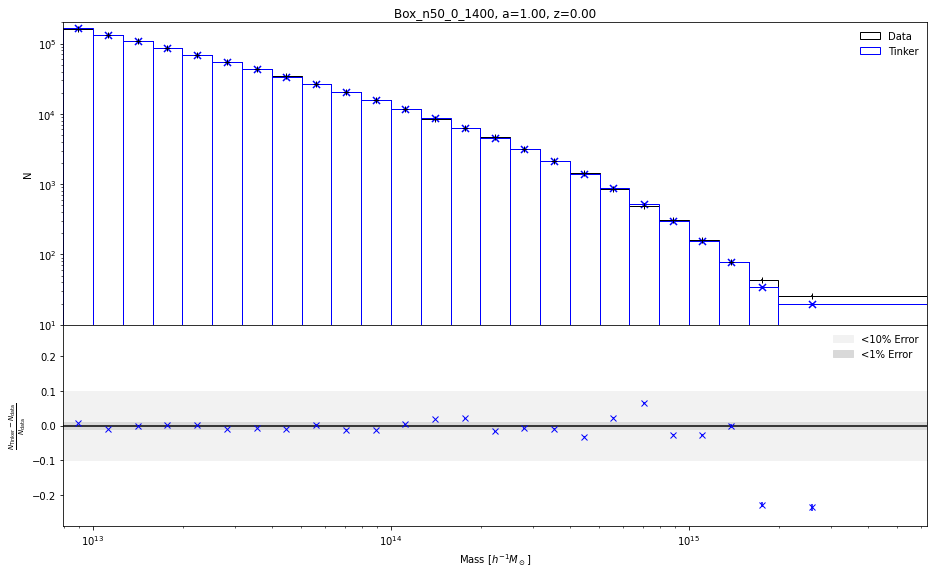

In [32]:
yerr_dict = {a:np.sqrt(np.diagonal(weighted_cov[a])) for a in weighted_cov} 
c_params = MLE_params
a = a_fit

fig1 = plt.figure(figsize =(12, 7))

axs=[fig1.add_axes((0.0,0.4,1,.6)), fig1.add_axes((0.0,0.0,1,.4))]
plt.subplots_adjust(wspace=0, hspace=0)
c_data = NvMs[a]

Ms = M_data[a]
N = N_data[a]
edge_pairs = c_data['edge_pairs']

edges = [edge[0] for edge in edge_pairs]
edges += [edge_pairs[-1][1]]

yerr = yerr_dict[a]
dM = np.array([edges[1]-edges[0] for edges in edge_pairs])


tinker_evaled = mass_function(ccl_cosmo, M_numerics/h, a_fit)*vol/(h**3 * M_numerics * np.log(10))

f_dNdM =  interp1d(M_numerics, tinker_evaled, kind='linear', bounds_error=False, fill_value=0.)

tinker_eval_MCMC = np.array([quad(f_dNdM, edge[0],  edge[1], epsabs=0, epsrel=1e-5)[0] for edge in edge_pairs])



axs[0].errorbar(Ms, N, yerr, fmt='+', c='black')
axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')

edges = np.array(edges)
axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
           align='edge', fill=False, ec='black', label='Data')
axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), align='edge', fill=False, ec='blue', label='Tinker')
axs[1].errorbar(Ms, (tinker_eval_MCMC-N)/N, yerr/N, fmt='x', color='blue')

y1 = 0.1*np.ones_like(N)
y1 = np.append(y1, y1[-1])
y1 = np.append(y1[0], y1)

y2 = -0.1*np.ones_like(N)
y2 = np.append(y2, y2[-1])
y2 = np.append(y2[0], y2)

c_Ms = np.append(Ms, edges[-1])
c_Ms = np.append(edges[0], c_Ms)
axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

y1 = 0.01*np.ones_like(N)
y1 = np.append(y1, y1[-1])
y1 = np.append(y1[0], y1)

y2 = -0.01*np.ones_like(N)
y2 = np.append(y2, y2[-1])
y2 = np.append(y2[0], y2)

axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')


axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend(frameon=False)
axs[0].set_ylabel('N')

axs[1].set_xscale('log')
# axs[1].set_yscale('lin', linthresh=1e-2)    
axs[1].legend(frameon=False)
axs[1].axhline(0, c='black')
axs[1].set_ylabel('N')
axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
axs[1].set_ylabel(r'$\frac{N_{\rm Tinker}-N_{\rm data}}{N_{\rm data}} $')
axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, scaleToRedshift(a)))
axs[0].set_ylim(10, 2e5)
left = np.ceil(np.log10(200*Mpart) * 10) / 10
axs[0].set_xlim((10**left, np.max(edges)))
axs[1].set_xlim((10**left, np.max(edges)))
axs[1].set_ylim((-.29, .29))
axs[1].set_yticks([-.2, -.1, 0, .1, .2])
plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_fit_%.2f.pdf'%(box, a), bbox_inches='tight')

In [33]:
with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_params.pkl"%(box, a_fit), "wb") as f:
    pickle.dump(MLE_params, f)

In [34]:
with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_NvMfit_output.pkl"%(box, a_fit), "wb") as f:
    pickle.dump({'Ms':Ms, 'tinker_eval':tinker_eval_MCMC, 'N':N, 'edges':edges}, f)

In [45]:
mass_function(ccl_cosmo, M_numerics/h, a_fit).shape

(50,)

In [46]:
M_numerics.shape

(50,)

In [48]:
ccl_cosmo

<pyccl.cosmology.Cosmology>
	A_s     = 2.1010031500000003e-09
	Neff    = 3.044
	Omega_b = 0.04967698819336154
	Omega_c = 0.2673201158387168
	h       = 0.67
	m_nu    = (0.023570226666666666, 0.023570226666666666, 0.023570226666666666)
	n_s     = 0.97000003
	extra_parameters =
	HASH_ACCURACY_PARAMS = 0x1bdbc2fa4f449522

In [56]:
sum(ccl_cosmo['m_nu'])

0.07071068